In [ ]:
%matplotlib nbagg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display as display_dataframe
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from copy import deepcopy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import cv2

import os
pictures_folder = '/content/sample_data/'



In [ ]:
def display_image(image, title='image'):
    '''
    uses openCV to display 1 image in a new window
    '''
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def display_all_in_a_list(image_list, titles=None, scale_factor=1):
    '''
    image_list: a single image, or a list of images
    -----------------------------------
    uses matplotlib to display all images in 'image_list' in the same cell
    '''
    plt.rcParams['figure.figsize'] = [10*scale_factor, len(image_list)*5*scale_factor]
    _, axes = plt.subplots(len(image_list), 1)
    if len(image_list) == 1:
        axes.imshow(image_list[0])
        if titles is not None:
            axes.set_title(titles[0])
    else:
        for index in range(len(image_list)):
            axes[index].imshow(image_list[index])
            if titles is not None:
                axes[index].set_title(titles[index])
    plt.show()

def get_rectangle_boundary(segments, min_area=100):
    '''
    returns rect_coordinates, np.array(rect_segments)
    '''
    
    new_segments = np.zeros(segments.shape, dtype=segments.dtype)
    rect_coords = []

    count = 1
    for region in regionprops(segments):
        if region.area >= min_area:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect_coords.append(region.bbox)
            new_segments[minr:maxr, minc:maxc] = count
            count += 1
    
    return rect_coords, new_segments

In [ ]:
print("Available images: ", os.listdir(pictures_folder), end='\n\n')

#list of needed images
images = [cv2.imread(os.path.join(pictures_folder, 'main.jfif'), 0)]

print("Got", len(images), "image(s) with shapes:")
for image in images:
    print(image.shape)

Available images:  ['anscombe.json', 'README.md', 'main.jfif', 'california_housing_test.csv', 'california_housing_train.csv', 'mnist_test.csv', 'mnist_train_small.csv']

Got 1 image(s) with shapes:
(477, 898)


In [ ]:
processed_images = []
titles = []
for img in images:
    processed_images.append(img)
    titles += ['(0) Original Image']
    
    processed_images.append(cv2.threshold(img,127,255,cv2.THRESH_BINARY)[1])
    processed_images.append(cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)[1])
    processed_images.append(cv2.threshold(img,127,255,cv2.THRESH_TRUNC)[1])
    processed_images.append(cv2.threshold(img,127,255,cv2.THRESH_TOZERO)[1])
    processed_images.append(cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)[1])
    titles += ['(1) BINARY','(2) BINARY_INV','(3) TRUNC','(4) TOZERO','(5) TOZERO_INV']

    processed_images.append(cv2.threshold(img,127,255,cv2.THRESH_BINARY)[1])
    processed_images.append(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2))
    processed_images.append(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2))

    titles += ['(6) Global Thresholding (v = 127)', '(7) Adaptive Mean Thresholding', '(8) Adaptive Gaussian Thresholding']

    # global thresholding
    processed_images.append(cv2.threshold(img,127,255,cv2.THRESH_BINARY)[1])
    # Otsu's thresholding
    processed_images.append(cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1])
    # Otsu's thresholding after Gaussian filtering
    processed_images.append(cv2.threshold(cv2.GaussianBlur(img,(5,5),0), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1])
    titles += ['(9) Global Thresholding (v=127)', "(10) Otsu's Thresholding", "(11) Otsu's Thresholding"]

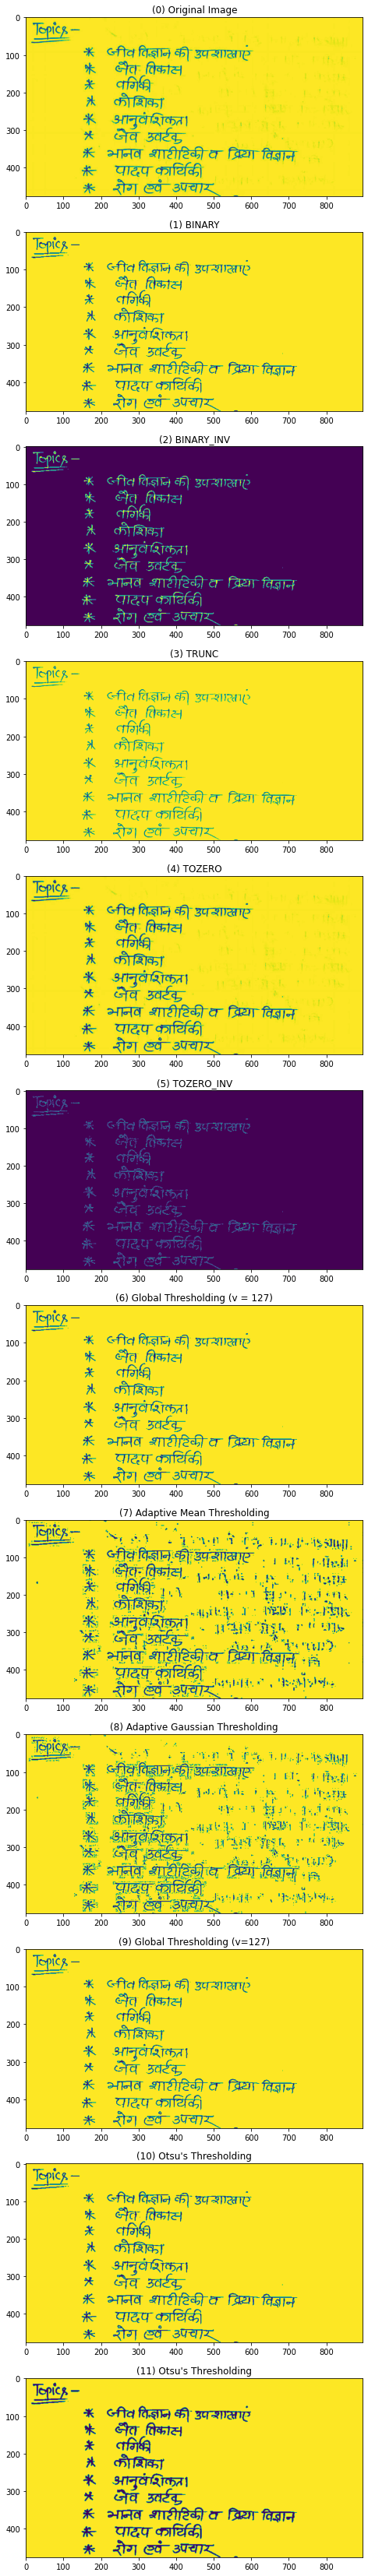

In [ ]:
display_all_in_a_list(processed_images, titles=titles)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from copy import deepcopy


import cv2

import os


image = deepcopy(processed_images[6])
rect_coords, rect_segments = get_rectangle_boundary(felzenszwalb(image, scale=5000, sigma=1, min_size=0))
# display_all_in_a_list([mark_boundaries(image, rect_segments)], titles=['Segmented Image'])
# display_image(image=mark_boundaries(image, rect_segments), title='Segmented Image')

In [ ]:
def order_in_pandas_dataframe(coordinates):
    '''
    takes a list of rectangular coordinates and returns a pd
    dataframe such that the words represented by the rectangular
    coordinates are in the order that they appear in the sentence
    '''
    df = pd.DataFrame(coordinates, columns=['y-', 'x-', 'y+', 'x+'])
#     df.sort_values(by=['y-', 'x-'], axis=0, inplace=True)
#     temp_df = pd.DataFrame(df['x-'] + df['y-'], columns=['sum']).sort_values(by='sum').index.values
#     df = df.iloc[temp_df]
    df['line'] = 0
    count = 1
    for i in range(df.shape[0]):
        if df['line'].iloc[i] == 0:
            #the first unmarked word comes into a new line
            df['line'].iloc[i] = count
            miny, maxy = df[['y-', 'y+']].iloc[i]
            
            #find all the words in the same line
            for j in range(df.shape[0]):
                if df['line'].iloc[j] == 0:
                    midy = (df['y-'].iloc[j] + df['y+'].iloc[j])/2
                    if midy < maxy and midy > miny:
                        df['line'].iloc[j] = count
            count += 1
            
    df = df.sort_values(['line', 'x-'])
            
    return df
    
rect_coords_in_order = order_in_pandas_dataframe(rect_coords)

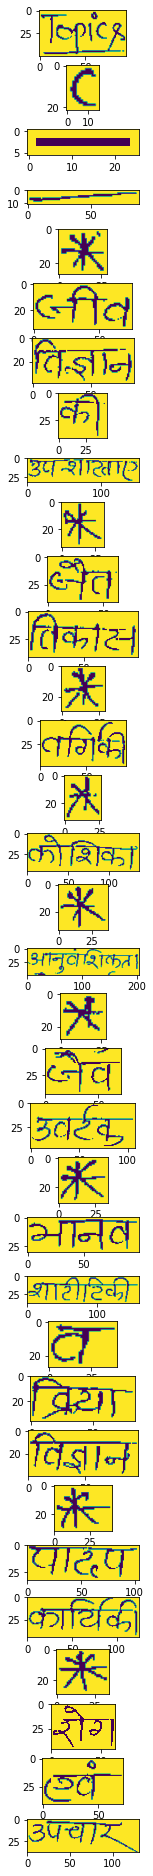

In [ ]:
words = [image[c['y-']:c['y+'], c['x-']:c['x+']] for _, c in rect_coords_in_order.iterrows()]
display_all_in_a_list(words, scale_factor=0.2)

In [ ]:
def fix_margin(image, pixels_in_margin):
    p = pixels_in_margin
    temp = np.lib.pad(np.array(image), ((p, p), (p, p)), 'constant', constant_values=255)
    
    #fixing vertical margin
    horizontal_sum = temp.sum(axis=1)
    all_white = max(horizontal_sum)
    start = -1
    end = 0
    for i in range(horizontal_sum.shape[0]):
        if horizontal_sum[i] != all_white:
            if start == -1:
                start = i
            end = i
    temp = temp[start-p : end+p, :]
                
    
    #fixing horizontal margin
    vertical_sum = temp.sum(axis=0)
    all_white = max(vertical_sum)
    start = -1
    end = 0
    for i in range(vertical_sum.shape[0]):
        if vertical_sum[i] != all_white:
            if start == -1:
                start = i
            end = i
    temp = temp[:, start-p : end+p]
    
    return temp

def filter_for_aa_ki_matra(image):
    a = image.sum(axis=0)
    aa_place = a.argmin()
    all_white = max(a)
    margin = (all_white-a[aa_place])//10
    a[(a > (all_white-margin)) | (a<a[aa_place]+margin)] = all_white
#     print(a)
    return np.all(a==all_white)

char_count = 0

listy = []

for word in words:
    temp = np.array(word) #without shiru rekha (for processing)
    temp_temp = np.array(temp) #with shiru rekha for dumping
    temp[:word.sum(axis=1).argmin()+1, :] = 255
    temp_temp[:word.sum(axis=1).argmin(), :] = 255
    vertical_sum = temp.sum(axis=0)
    all_white = max(vertical_sum)
    start = -1
#     end = -1
#     print(vertical_sum.shape)
    for i in range(vertical_sum.shape[0]):
        if start == -1:
            if vertical_sum[i] != all_white:
                start = i
        else:
            margin = 2
            if vertical_sum[i] == all_white:
#                 character_to_save = 
                #not saving aa ki matras because the classifier is not trained for them
                if not filter_for_aa_ki_matra(fix_margin(temp[:, start:i], margin)):
#                     listy.append(character_to_save)
#                     display_image(fix_margin(temp_temp[:, start:i], 1))
#                     break
                    cv2.imwrite("segmented_characters/"+str(char_count)+'.jpg', fix_margin(temp_temp[:, start:i], margin))
                    char_count += 1
                start = -1
                char_count += 1

NameError: ignored

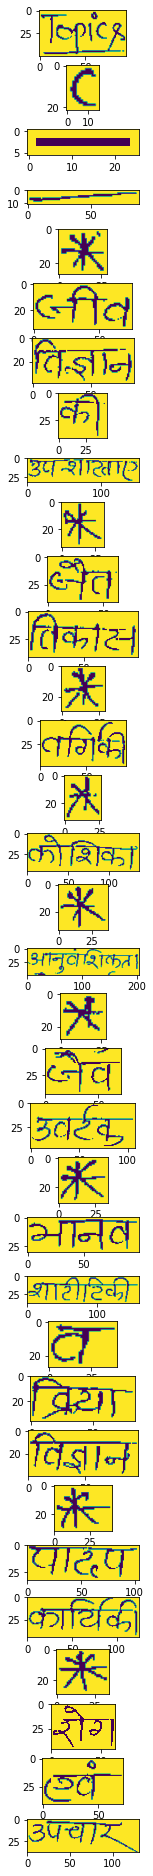

In [ ]:
display_all_in_a_list(words, scale_factor=0.2)